# <center>Ablation Study of Effect of Pretraining using SimCLR<center>

## Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets,models,transforms

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
#For Reproducibility purposes

manualSeed = 42
torch.manual_seed(manualSeed)

import random
random.seed(manualSeed)

np.random.seed(manualSeed)

if (device=='cuda'):
  torch.backends.cudnn.determinstic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Network

In [ ]:
class NeuralNet(nn.Module):

    def __init__(self,hidden_dim):
        super().__init__()
        self.cnn = torchvision.models.resnet18(pretrained=False,num_classes=4*hidden_dim)
        self.mlp = nn.Sequential(
                          nn.ReLU(inplace=True),
                          nn.Linear(4*hidden_dim,hidden_dim),
                                )
    
    def forward(self,x):
        x = self.cnn(x)
        x = self.mlp(x)
        return x

## Training function

In [ ]:
def train(dataloader,model,nb_epochs=100):
  
  model = model.to(device)
  model.train()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)
   
  losses = []
  for epoch in range(nb_epochs): 
    running_loss = 0
    for batch,(imgs,labels) in enumerate(dataloader):
      output = model(imgs.to(device))
      loss = loss_fn(output,labels.to(device))
      
      #Optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
    
    avg_loss = running_loss/(batch+1)
    losses.append(avg_loss)
    print(f'Training loss for epoch {epoch+1} = {avg_loss:.7f}')

  print('\nTraining has successfully finished !')
  return losses

## Testing function

In [ ]:
def test(dataloader,model):

  model = model.to(device)
  model.eval()
  loss_fn = nn.CrossEntropyLoss()

  total = 0
  correct = 0
  for batch,(imgs,labels) in enumerate(dataloader):
    output = model(imgs.to(device))
    
    total += labels.size(0)
    correct += (output.argmax(dim=1) == labels.to(device)).sum().item()

  print(f'Accuracy on Testing set = {100*(correct/total):.3f}% [{correct}/{total}]')

## Finetuning 

In [ ]:
simclr = torch.load("/content/gdrive/MyDrive/Pretrained models/simclr.pth")

In [ ]:
simclr.cnn.fc = nn.Linear(512,10)
simclr.mlp = nn.Identity()
print(simclr)

NeuralNet(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,),(0.5,))
                                     ])

train_data = datasets.STL10(root='./data',split='train',download=True,transform=train_transforms)
train_dataloader = DataLoader(train_data,batch_size=32,shuffle=True,pin_memory=True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data


In [ ]:
simclr_losses = train(train_dataloader,simclr,nb_epochs=80)

Training loss for epoch 1 = 2.1690618
Training loss for epoch 2 = 1.8986224
Training loss for epoch 3 = 1.7125462
Training loss for epoch 4 = 1.5730343
Training loss for epoch 5 = 1.4638788
Training loss for epoch 6 = 1.3809225
Training loss for epoch 7 = 1.3089289
Training loss for epoch 8 = 1.2534424
Training loss for epoch 9 = 1.2048359
Training loss for epoch 10 = 1.1633676
Training loss for epoch 11 = 1.1283555
Training loss for epoch 12 = 1.1018220
Training loss for epoch 13 = 1.0774222
Training loss for epoch 14 = 1.0503039
Training loss for epoch 15 = 1.0246534
Training loss for epoch 16 = 1.0122037
Training loss for epoch 17 = 0.9903446
Training loss for epoch 18 = 0.9741026
Training loss for epoch 19 = 0.9550229
Training loss for epoch 20 = 0.9516654
Training loss for epoch 21 = 0.9332973
Training loss for epoch 22 = 0.9235441
Training loss for epoch 23 = 0.9201380
Training loss for epoch 24 = 0.9049761
Training loss for epoch 25 = 0.8965019
Training loss for epoch 26 = 0.880

## Baseline

In [ ]:
baseline = models.resnet18(pretrained=False,num_classes=10)
print(baseline)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
train_transforms = transforms.Compose([
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
                                       transforms.RandomGrayscale(p=0.2),
                                       transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
]) #To match the data used to pretrain.

train_data = datasets.STL10(root='./data',split='train',download=True,transform=train_transforms)
train_dataloader = DataLoader(train_data,batch_size=32,shuffle=True,pin_memory=True)

Files already downloaded and verified


In [ ]:
baseline_losses = train(train_dataloader,baseline,nb_epochs=80)

Training loss for epoch 1 = 2.2881346
Training loss for epoch 2 = 2.1858332
Training loss for epoch 3 = 2.1027970
Training loss for epoch 4 = 2.0113022
Training loss for epoch 5 = 1.9287318
Training loss for epoch 6 = 1.8687007
Training loss for epoch 7 = 1.8113373
Training loss for epoch 8 = 1.7692886
Training loss for epoch 9 = 1.7325066
Training loss for epoch 10 = 1.6998536
Training loss for epoch 11 = 1.6741047
Training loss for epoch 12 = 1.6465564
Training loss for epoch 13 = 1.6309565
Training loss for epoch 14 = 1.6068681
Training loss for epoch 15 = 1.5923691
Training loss for epoch 16 = 1.5723376
Training loss for epoch 17 = 1.5593950
Training loss for epoch 18 = 1.5551972
Training loss for epoch 19 = 1.5230585
Training loss for epoch 20 = 1.5222919
Training loss for epoch 21 = 1.5044964
Training loss for epoch 22 = 1.5019538
Training loss for epoch 23 = 1.4738708
Training loss for epoch 24 = 1.4688450
Training loss for epoch 25 = 1.4643871
Training loss for epoch 26 = 1.445

## Ablation Study

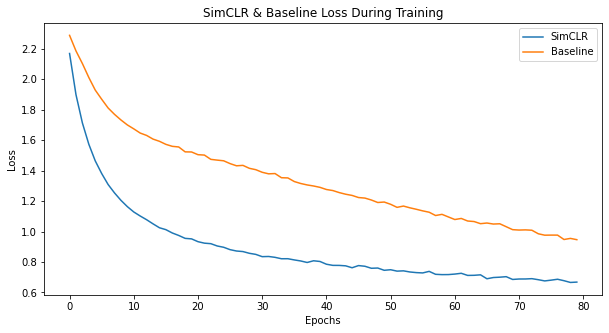

In [ ]:
#Plot of SimCLR & Baseline's losses during Training
plt.figure(figsize=(10,5))
plt.title("SimCLR & Baseline Loss During Training")
plt.plot(simclr_losses,label="SimCLR")
plt.plot(baseline_losses,label="Baseline")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,),(0.5,))
])

test_data = datasets.STL10(root='./data',split='test',download=True,transform=test_transforms)
test_dataloader = DataLoader(test_data,batch_size=32,shuffle=False,pin_memory=True,num_workers=1)

Files already downloaded and verified


In [ ]:
print('For Neural Network pretrained using SimCLR:')
test(test_dataloader,simclr)
print('\nFor Baseline:')
test(test_dataloader,baseline)

For Neural Network pretrained using SimCLR:
Accuracy on Testing set = 75.613% [6049/8000]

For Baseline:
Accuracy on Testing set = 55.612% [4449/8000]


## Conclusion

As we can see, the Neural network which is pretrained using SimCLR performs better than our baseline network. Which means that the network has learned meaningful representations.